#### Sequential Learning App for Materials Discovery - *SLAMD*

In [1]:
#Imports
import base64

from resample.jackknife import resample as b_resample
from numpy import random
import ipywidgets as widgets
from ipywidgets import RadioButtons,FloatRangeSlider,Button,IntSlider
from IPython.display import display,Markdown,HTML
import pandas as pd
import sys
import statistics
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance_matrix

#import imsl.data_mining as dm

import time
import seaborn as sns
import threading

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as SKRFR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing
#FUELS-imports
from lolopy.learners import RandomForestRegressor
from operator import add
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import Colormap

In [2]:
#Components

tab = widgets.Tab()    

out = widgets.Output(layout={'border': '1px solid black'})
out_plotting= widgets.Output(layout={'border': '1px solid black'})

out_perform_experiment=widgets.Output(layout={'border': '1px solid black'})
   

out_algo=widgets.Output(layout={'border': '1px solid black'})
out_algo_alt=widgets.Output(layout={'border': '1px solid black'})


out_input_space=widgets.Output(layout={'border': '1px solid black'})

out_res=widgets.Output(layout={'border': '1px solid black'})


up = widgets.FileUpload(accept="", multiple=False)

delim = widgets.RadioButtons(
    options=[';', ','],
    description='Separator: ',
    disabled=False)

delim_dec = widgets.RadioButtons(
    options=[',', '.'],
    description='Decimal Delim: ',
    disabled=False)

eraser = widgets.SelectMultiple(
    options=['tab','"',"%"],
    value=['tab'],
    #rows=10,
    description='Eraser: ',
    disabled=False)

rows = widgets.IntSlider(
    value=0,
    step=1,
    description='# of lines:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

##ML-###pre processing

feature_selector=widgets.SelectMultiple(
    options=[],
    #tooltip("Select the Input Features")
    #rows=10,
    description='Features',
    disabled=False,
layout=widgets.Layout(width='50%'))
    
target_selection=widgets.SelectMultiple(
    options=[],
    #value='',
    placeholder='select the Target Variable',
    description='Target-Variable',
    disabled=False,
layout=widgets.Layout(width='50%'))


selector_plot_variable=widgets.SelectMultiple(
    options=[],
    #tooltip("Select the Input Features")
    #rows=10,
    description='Features',
    disabled=False,
layout=widgets.Layout(width='50%'))
    



graph_type = widgets.Dropdown(
    options=['Choose the Graph Type','Scatter', 'Scatter Matrix', 'Correlation Heatmap'],
    value='Choose the Graph Type',
    description='Chart Type:',
    disabled=False,
    layout=widgets.Layout(width='50%'))

x_axis = widgets.Dropdown(
    options=[''],
    value='',
    description='X-Axis:',
    disabled=False)
y_axis = widgets.Dropdown(
    options=[''],
    value='',
    description='Y-Axis:',
    disabled=False)
color_picker = widgets.ColorPicker(
    concise=False,
    description='Color Picker: ',
    value='lightblue',
    disabled=False)
toggle = widgets.ToggleButtons(
    options=['Preview  ', 'Info  ', 'Stats  '],
    description='Options',
    disabled=False,
    button_style='warning',
    icons=['search', 'info', 'tachometer'])

select_x=widgets.Dropdown(
    options=[''],
    value='',
    placeholder='select X-Axis',
    description='X-Axis:',
    disabled=False,
layout=widgets.Layout(width='50%'))
select_y=widgets.Dropdown(
    options=[''],
    value='',
    placeholder='select Y-Axis',
    description='Y-Axis:',
    disabled=False,
layout=widgets.Layout(width='50%'))

select_hue=widgets.Dropdown(
    options=[''],
    value='',
    placeholder='select the hue',
    description='Hue:',
    disabled=False,
layout=widgets.Layout(width='50%'))

select_size=widgets.Dropdown(
    options=[''],
    value='',
    placeholder='select the Size',
    description='Size:',
    disabled=False,
layout=widgets.Layout(width='50%'))


select_strategy=widgets.Dropdown(
    options=['MEI (exploit)','MU (explore)','MLI (explore & exploit)','MEID (exploit)','MLID (explore & exploit)'],
    value='MEI (exploit)',
    placeholder='select the strategy',
    description='Strategy:',
    disabled=False,
layout=widgets.Layout(width='50%'))

select_model=widgets.Dropdown(
    options=['lolo Random Forrest (RF) - quick (requ. min 8 init. samples)','Decision Trees (DT) - quick','Random Forrest (RFscikit) - quick','Gaussian Process Regression (GPR) - quick'],
    value='Decision Trees (DT) - quick',
    placeholder='select the Model',
    description='Model:',
    disabled=False,
layout=widgets.Layout(width='50%'))


button_confirm_strategy=widgets.Button(
    description='Confirm Strategy ',
    disabled=False,
    button_style='success',
    tooltip='Confirm selected Strategy',
    icon='check',
layout=widgets.Layout(width='50%',height ='inherit'))


#Options
box_features=widgets.VBox([])




#container_feature_options=widgets.VBox([widgets.HBox([box_features,box_features_slider]),box_confirm])
#feature_options= widgets.Accordion(children=[container_feature_options])

#feature_options.set_title(0,"Specify your Target")

In [3]:
#Buttons Anfang
button_upload = widgets.Button(
    description='Upload',
    disabled=False,
    button_style='success',
    tooltip='Click to Upload',
    icon='check',
layout=widgets.Layout(width='50%'))

button_preview = widgets.Button(
    description='Preview',
    disabled=False,
    button_style='info',
    tooltip='Click to Preview',
    icon='search',
layout=widgets.Layout(width='50%'))



#Plotting
button_plot = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='warning',
    tooltip='Click to Plot',
    icon='pencil',
layout=widgets.Layout(width='100%'))




###Algos
button_confirm_feature=widgets.Button(
    description='Select Features ',
    disabled=False,
    button_style='success',
    tooltip='Confirm Feature Selection of Training Features',
    icon='check',
layout=widgets.Layout(width='50%',height ='inherit'))

button_confirm_target=widgets.Button(
    description='Select Target',
    disabled=False,
    button_style='success',
    tooltip='Confirm the selected Target Variable',
    icon='check',
layout=widgets.Layout(width='50%',height ='inherit'))

button_show_DS=widgets.Button(
    description='Visualize Settings',
    disabled=False,
    button_style='success',
    tooltip='Plots Design Space with candidates and targets',
    icon='search',
layout=widgets.Layout(width='50%',height ='inherit'))



button_confirm_plot_var=widgets.Button(
    description='Confirm Selection',
    disabled=False,
    button_style='success',
    tooltip='Confirm the selected Target Variable',
    icon='check',
    layout=widgets.Layout(width='50%',height ='inherit'))

button_plot_comparision=widgets.Button(
    description='Compare',
    disabled=False,
    button_style='warning',
    tooltip='Simplify the Columns',
    icon='fa-bar-chart',
    layout=widgets.Layout(width='50%')
)


button_confirm_options=Button(
    description='Confirm Options ',
    disabled=False,
    button_style='success',
    tooltip='Confirm options',
    icon='check',
    layout=widgets.Layout(width='50%',height ='inherit'))
                           
###Algos ende
##ML End

button_custom_strategey=widgets.Button(
    description='Customize',
    disabled=False,
    button_style='warning',
    tooltip='Simplify the Columns',
    icon='fa-bar-chart',
    layout=widgets.Layout(width='50%')
       
    
)
button_perform_experiment=widgets.Button(
    description='Run',
    disabled=False,
    button_style='warning',
    tooltip='Perform Experiment',
    icon='fa-calculator',
    layout=widgets.Layout(width='100%'))


button_cancel_experiment=widgets.Button(
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop Experiment',
    icon='fa-stop',
    layout=widgets.Layout(width='100%'))
    
#Buttons Ende

In [4]:
#FileUpload Tab
accordion = widgets.Accordion(children=[
    up, 
    widgets.HBox([delim, delim_dec, eraser]), 
    rows])

accordion.set_title(0, 'File Selection')
accordion.set_title(1, 'Delimiter')
accordion.set_title(2, 'Skip Rows')


accordion_box = widgets.VBox([
    accordion, 
    widgets.HBox([button_preview, button_upload ]),
    out
])

In [5]:
#Sequential Learning Tab 
slider_of_for_dist=widgets.FloatSlider(
    value=95,
    min=0,
    max=100,
    step=1,
    description='Prediction quantile for distance-based utility (smaller values recommended for weak predictors).:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    
    layout=widgets.Layout(width='50%')
)

slider_of_for_std=widgets.FloatSlider(
    value=1,
    min=0.1,
    max=5,
    step=0.1,
    description='σ Factor (to controll the weigth of uncertainty):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    
    layout=widgets.Layout(width='50%')
)
quantile_tar_slider= widgets.FloatSlider(
    value=95,
    min=1,
    max=100,
    step=1,
    description='Target threshold (Quantile):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    
    layout=widgets.Layout(width='50%')
)


quantile_sample_slider= widgets.FloatSlider(
    value=50,
    min=1,
    max=100,
    step=5,
    description='Sample threshold (Quantile):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    
    layout=widgets.Layout(width='50%')
)
initial_sample_size_text=widgets.BoundedIntText(
    value=4,
    min=2,
    max=20,
    step=1,
    description='Initial Sample Size:',
    disabled=False,
    layout=widgets.Layout(width='50%')
)

#slider_quantile_container=widgets.VBox([widgets.HBox(children=[quantile_tar_slider,quantile_sample_slider,initial_sample_size_text])])

box_features_slider=widgets.VBox([])


plottingDS=widgets.VBox(children=[widgets.VBox( [
        #container_plot_options,
        out_input_space
    ]
)])

DataPre_sl=widgets.VBox([
        widgets.HBox([feature_selector, button_confirm_feature]),
        widgets.HBox([target_selection, button_confirm_target]),
#      slider_quantile_container,

    box_features,
    quantile_tar_slider,
    quantile_sample_slider,
    initial_sample_size_text,
    button_show_DS,
    plottingDS
    
])


    



DataPre=widgets.VBox([
        widgets.HBox([feature_selector, button_confirm_feature ]),
        widgets.HBox([target_selection, button_confirm_target]),
       
    
])

iterations=widgets.IntSlider(
    value=30,
    min=1,
    max=100,
    step=1,
    description='# of SL runs:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='50%')
)

custom_container=widgets.VBox([widgets.HBox([])])
results_container=widgets.VBox([widgets.HBox([])])
strategy_container=widgets.HBox([select_strategy, button_confirm_strategy ])

start_and_stop_sl_container=widgets.HBox([button_perform_experiment])

sl_settings= widgets.VBox([
    strategy_container,
    custom_container,
    widgets.HBox([select_model,iterations]),
    start_and_stop_sl_container,
    out_perform_experiment
   
    
])



sl_accordion=widgets.Accordion(children=[DataPre_sl,sl_settings])
sl_accordion.set_title(0,"Settings")
sl_accordion.set_title(1,"Sequential Learning Parameters")

In [6]:
#Plotting Tab

container_plot_options= widgets.VBox([])
button_container=widgets.HBox([button_plot])

plotting=widgets.VBox(children=[widgets.VBox( [
        widgets.HBox([graph_type]),
        container_plot_options,
        button_container,
        out_plotting
        
        
]


)])

children = [
    accordion_box, 
    widgets.VBox([toggle, out]),
    plotting,
    #plot_accordion,
    sl_accordion
    
   ]

In [7]:
#Tabs
tab.children = children
tab.set_title(0, "Upload")
tab.set_title(1, "Data Info")
tab.set_title(2, "Design Space Explorer")
tab.set_title(3, "Sequential Learning")

In [8]:
#EventHandling

def plot_TSNE_input_space():
            features_df=(df_converter()[confirm_features()]-df_converter()[confirm_features()].mean())/df_converter()[confirm_features()].std()
        
            target_df=(df_converter()[confirm_target()]-df_converter()[confirm_target()].mean())/df_converter()[confirm_target()].std()       

            tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
            tsne_results = tsne.fit_transform(features_df)

            with out_input_space:
                # Plot Results in reduced FS
                out_input_space.clear_output(wait=True)
                fig3= plt.figure(figsize=(10, 6))
                targ_q = quantile_tar_slider.value/100
                samp_q = quantile_sample_slider.value/100
                sum_ = target_df.sum(axis=1).to_frame()
                targ_q_t= sum_.quantile(targ_q)
                samp_q_t=sum_.quantile(samp_q)
                
                cmap = plt.get_cmap('cool', 200)
                cmap.set_under('dimgray') 
                cmap.set_over('lawngreen')
                sc=plt.scatter(x=tsne_results[:,0],y=tsne_results[:,1], c=sum_, cmap=cmap, vmin=samp_q_t.values, vmax=targ_q_t.values-0.01)
                cbar=plt.colorbar(sc,extend='both')
                #ticklabs = cbar.ax.get_yticklabels()
                cbar.ax.set_yticklabels([ ]) 
                cbar.ax.set_ylabel('targets (green)                to be explored            initial candidate pool (gray)', rotation=270 ,va='center')

                plt.title("Design space in TSNE-coordinates: candidate pool and targets")
                plt.show()
                        
                plt.close(fig3)

def content_parser():
    if up.value == {}:
        """with out:
            out.clear_output
            display(Markdown('No CSV loaded'))
            #print('No CSV loaded')    """
    else:
        typ, content = "", ""
        up_value = up.value
        for i in up_value.keys():
            typ = up_value[i]["metadata"]["type"]
            if typ == "text/csv" or typ == "application/vnd.ms-excel":
                content = up_value[i]["content"]
                content_str = str(content, 'utf-8')

                if eraser.value != {}: 
                    for val in eraser.value:
                        if val == "tab":
                            content_str = content_str.replace("\t","")
                        elif val =="%":
                            content_str = content_str.replace("\t","")
                        else:
                            content_str = content_str.replace(val,"")
                if content_str != "":
                    str_io = StringIO(content_str) 
                    return str_io
def df_converter():
    content = content_parser()
    if content is not None:
            df = pd.read_csv(content, sep=delim.value, index_col=False, skiprows=rows.value,decimal=delim_dec.value)
            df=df.apply(pd.to_numeric,errors="coerce")
            
            
            
                
            return df
    else:
        return None
    
    
def preview():
    
    df = df_converter()
    with out:
        out.clear_output()
        display(Markdown('This is your data:'))
        
        if df is not None:
            display(Markdown(df.head(10).to_markdown()))
        else:
            display(Markdown('Configuration is wrong/missing...'))
            
def upload():
    
    df = df_converter()
    with out:
        out.clear_output()
        display(Markdown('This is how your uploaded data looks like:'))
       
        if df is not None:
            display(Markdown(df.head(10).to_markdown()))
            x_axis.options = df.columns
            y_axis.options = df.columns
            feature_selector.options= df.columns
            select_x.options=df.columns
            select_y.options=df.columns
            select_size.options=df.columns
            select_hue.options=df.columns
            selector_plot_variable.options=df.columns
            
        else:
            display(Markdown('Configuration is wrong/missing...'))

            
            
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
           
            
            
def desc():
    info_level = toggle.value
    if info_level != {}:
        df = df_converter()
        with out:
            out.clear_output()
            
            print('\n ------ Data {} ------ \n'.format(
                info_level))
            if df is not None:
                if info_level == 'Info  ':
                    print(df.info(verbose=True))
                elif info_level == 'Stats  ':
                    print(df.describe())
                elif info_level == 'Preview  ':
                    display(Markdown(df.head(10).to_markdown()))
                else:
                    display(Markdown('Configuration is wrong/missing...'))
       




    
def plot():
    graph = graph_type.value
    if graph=="Scatter":
        plot_scatter()
    elif graph=="Correlation Heatmap":
            plot_heat()
    elif graph=="Scatter Matrix":
            plot_pairwise()
          
# def plotDS():
      
        
def plot_pairwise():
    
    df =confirm_var()
    
    with out_plotting:
        out_plotting.clear_output()
        sns.pairplot(df)
        plt.show()

def plot_heat():
    
    df = confirm_var()
    
    with out_plotting:
        out_plotting.clear_output()
        corr = df.corr()

        plt.figure(figsize=(12,7))
        sns.heatmap(corr, annot=True, cmap='Blues')
        b, t = plt.ylim()
        plt.ylim(b+0.5, t-0.5)
        plt.title("Feature Correlation Heatmap")
        plt.show()
            
def plot_scatter():
    data=df_converter()
    with out_plotting:
        out_plotting.clear_output()
        fig, ax = plt.subplots(figsize=(12,7))
        #not generic
        sns.scatterplot(y=select_y.value, x=select_x.value, hue=select_hue.value, size=select_size.value, data=data, ax=ax, sizes=(50, 300))
        ax.set_title(select_y.value+ "vs"+ select_x.value)
        ax.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.show()
        plt.close(fig)      

In [9]:
#ml eventhandling
#pre pocessing

def confirm_options():
    items=box_features_slider.children
    df = df_converter()
    Y = df.loc[:,df.columns.isin(target_selection.value)]
    
    for slider in items:
            unt_grenz= slider.value[0]/100
            ob_grenz= slider.value[1]/100
            Y = Y[(Y >= Y.quantile(unt_grenz) ) & (Y <= Y.quantile(ob_grenz))]
            Y= Y.dropna()
    
    return Y   

#returns index of features
def confirm_features():
    df = df_converter()
    train = feature_selector.value
    target_selection.options=df.columns[~df.columns.isin(feature_selector.value)]
    train = df.columns[df.columns.isin(feature_selector.value)]
    return train
    
def confirm_var():
    df= df_converter()
    #df.columns[df.columns.isin(feature_selector.value)]
    #var = df.columns[df.columns.isin(selector_plot_variable.value)]
    selection = list(selector_plot_variable.value)
    var = df[selection]
 
    return var

    
#returns index of target    
def confirm_target():
    df = df_converter()
    #target_Var=target_selection.value
    #feature_selector.options= get_features()
    target = df.columns[df.columns.isin(target_selection.value)]
    
    
    if(len(box_features.children) == 0):
        create_dynamically_checkboxes()
   
    
    return target 
    
    
def create_slider_for_dist_quantile():
    strategy_container.children=[select_strategy,slider_of_for_dist,  button_confirm_strategy]
    
def create_slider_for_dist_quantile_std():
    strategy_container.children=[select_strategy,slider_of_for_dist, slider_of_for_std,  button_confirm_strategy]
        
def create_slider_for_std():
    strategy_container.children=[select_strategy,slider_of_for_std,  button_confirm_strategy]
    
def create_dynamically_checkboxes():
    target= target_selection.value
    items = [RadioButtons(
    options=['maximize', 'minimize'],
    value='maximize', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description=feature,
    disabled=False
) for feature in target]
    box_features.children=items

In [10]:
#result_df = pd.DataFrame(columns=['Requ. experiments (mean)','Requ. experiments (std)','Requ. experiments (90%)','Requ. experiments (max)','Algorithm','Utlity Function','σ Factor','qant. (distance utility)','# SL runs','Initial Sample','# of samples in the DS','# Features','# Targets', 'Target threshold','Sample threshold'])
result_df = pd.DataFrame(columns=['Requ. experiments (mean)','Requ. experiments (std)','Requ. experiments (90%)',
                                  'Requ. experiments (max)','Algorithm','Utlity Function','σ Factor',
                                  'qant. (distance utility)','# SL runs','Initial Sample','# of samples in the DS',
                                  '# Features','# Targets', 'Target threshold','Sample threshold','Features name','Targets name',
                                  'Req. experiments (all)'])



In [11]:
class sequential_learning:
    
    xlabel="Sequential Learning Iteration"
    
    init_sample_size=4
    number_of_executions=0
    features_df=df_converter()
    target_df=df_converter()
    targ_q=quantile_tar_slider.value
    samp_q=quantile_sample_slider.value
    min_distances_list=[]
    dataframe =df_converter()
    
    
    tries_list=np.empty(iterations.value)
    
    tries_list_rand_pick=np.empty(iterations.value)
    
    
    y_pred_dtr_mean=None
    y_pred_dtr_std=None
    y_pred_dtr=None
    SampIdx=None
    PredIdx=None
    
   
        
    def __init__(self,dataframe,cancelbutton,runbutton):  #constructor
        self.thread = None
        self.run = runbutton
        self.stop = cancelbutton
        self.stop.on_click(self.stopTime)
        self.run.on_click(self.start_thread)
        self.stopTimer = False
        self.thread = None
        self.buttonState = "Start"
        self.dataframe = dataframe
        
    
        
    def apply_feature_selection_to_df(self,df):
        if(df is not None):
            self.features_df = df[confirm_features()]    
    
    def apply_target_selection_to_df(self,df):
        if(df is not None):
            self.target_df= df[confirm_target()]    

        
    def standardize_data(self,df):
        if(df is not None):
            dataframe_norm=(df-df.mean())/df.std()
            target_df_norm=(self.target_df-self.target_df.mean())/self.target_df.std()
            features_df_norm=(self.features_df-self.features_df.mean())/self.features_df.std()
            self.features_df=features_df_norm
            self.target_df=target_df_norm
            self.dataframe=dataframe_norm
            
        return self.features_df, self.target_df, self.dataframe
        
    
    def set_init_sample_size(self):
        self.init_sample_size=initial_sample_size_text.value
    
        
    def set_number_of_ex(self):
        self.number_of_executions= iterations.value
        
    

    def init_sampling(self,df):
        if(df is not None):
            self.samp_q= quantile_sample_slider.value/100
            chosen_columns = confirm_target()


            #sum dataframe
            sum_ = df[chosen_columns].sum(axis=1).to_frame()

            #sample quantile to restrict initial sampling 
            samp_q_t=sum_.quantile(self.samp_q)

            Index_label=np.where(sum_ < samp_q_t )
            Index_label=Index_label[0]

            init_sample_set = np.ones((0,self.init_sample_size))


            for i in range(self.number_of_executions):

                        init_sample_set=np.vstack([init_sample_set, random.choice(Index_label,self.init_sample_size)])

        return init_sample_set
    
    def decide_max_or_min(self):
        
        max_or_min_optimizations_list=[]
        
        for decide in range(len(self.target_df.columns)):
            
                            
            max_or_min_optimizations_list.append(box_features.children[decide].value)
        
        return max_or_min_optimizations_list
            
    def start_sequential_learning(self):
        self.tries_list=np.empty(iterations.value)
        self.tries_list.fill(np.nan)
        self.tries_list_rand_pick=np.empty(iterations.value)
        self.tries_list_rand_pick.fill(np.nan)
        distances=[]
        targt_perfs=[]
        current_distances_list=[]   
        current_targt_perf_list=[] 
        with out_perform_experiment:
                display(Markdown('Sequential Learning is running...'))
                 

        init_sample_set=self.init_sampling(self.dataframe)
        global result_df    
        
        for i in range(self.number_of_executions):
                
                if(self.buttonState == "Start"):
                        self.perform_random_pick(i)
                        self.SampIdx=init_sample_set[i].astype(int)
                        self.PredIdx=self.dataframe
                        self.PredIdx = self.PredIdx.drop(self.PredIdx.index[self.SampIdx]).index
                        
                        #init train
                        self.decide_model(select_model.value)
                        self.tries_list[i]=self.init_sample_size
                        decide_optimization=self.decide_max_or_min()

                        for k in decide_optimization:
                            index_of_target = decide_optimization.index(k)

                            if (k == "minimize"): 
                                self.target_df.iloc[:,index_of_target]*(-1)



                        #set quantile
                        self.targ_q = quantile_tar_slider.value/100
                        sum_ = self.dataframe[confirm_target()].sum(axis=1).to_frame()
                        targ_q_t= sum_.quantile(self.targ_q)

                        current_targt_perf_list=[]
                        current_distances_list=[]

                        schwellwert=sum_.quantile(self.targ_q)
                        Index_c=np.where(sum_ >= schwellwert )
                        Index_c=Index_c[0]
                        distance=distance_matrix(self.dataframe.loc[self.SampIdx],self.dataframe.iloc[Index_c])
                        distance=distance.min()
                        current_distances_list=[distance]
                        targt_perf=sum_.loc[self.SampIdx].max().values.tolist()
                        targt_perf=max(targt_perf)
                        current_targt_perf_list=[targt_perf] 
        
                        while sum_.loc[self.SampIdx].max().values <= targ_q_t.values:
                                       

                                        #Update_Idx_with_Strategy 
                                        self.update_strategy(confirm_strategy())

                                        #Train Model
                                        self.decide_model(select_model.value)

                                        schwellwert=sum_.quantile(self.targ_q)
                                        Index_c=np.where(sum_ >= schwellwert )
                                        Index_c=Index_c[0]

                                        distance= distance_matrix(self.dataframe.loc[self.SampIdx],self.dataframe.iloc[Index_c])
                                        distance=distance.min()
                                        current_distances_list.append(distance)

                                        targt_perf=sum_.loc[self.SampIdx].max().values.tolist()
                                        targt_perf=max(targt_perf)
                                        current_targt_perf_list.append(targt_perf)
                                        self.tries_list[i]=self.tries_list[i]+1   
                        
                        distances.append(current_distances_list)
                        targt_perfs.append(current_targt_perf_list)
                        #print(targt_perfs)

                        ##Distance Plot

                        #with out_perform_experiment:
                        fig1,axs = plt.subplots(1,2,figsize=(20, 8))
                        axs[0].set_title('Progress per iteration in the input space')
                        axs[0].set_xlabel('SL iterations')
                        axs[0].set_ylabel("Minimum distance from sampled data to target")
                        axs[0].axhline(y=0, color='k', linestyle=':',label='Target')
                        axs[0].legend()

                        axs[1].set_title('Progress per iteration in the output space')
                        axs[1].set_xlabel('SL iterations')
                        axs[1].set_ylabel("Maximum sampled property")
                        axs[1].axhline(y=targ_q_t.values, color='k', linestyle=':',label='Target (normalized)')
                        axs[1].legend()

                        for runs in range(len(distances)):
                            axs[0].plot(distances[runs],linewidth=8, alpha=0.4)

                        for runs in range(len(targt_perfs)):    
                            axs[1].plot(targt_perfs[runs],linewidth=8, alpha=0.4)

                            #plt.close(fig1)
                        with out_perform_experiment:
                            out_perform_experiment.clear_output(wait=True)
                            time.sleep(1.0)
                            fig2=plt.figure(figsize=(10, 6))
                            plt.xlabel('Number of required Experiments')
                            plt.ylabel("Frequency")
                            plt.title("Performance histogram for %s with strategy %s "%(select_model.value,select_strategy.value))
                            #plt.hist([self.tries_list,self.tries_list_rand_pick],bins=len(self.tries_list),label=['SL Tries', 'Random Pick Tries'])         
                            plt.hist([self.tries_list_rand_pick],range=(1, len(self.features_df)),label=['Random Process'],alpha=0.4)         
                            plt.hist([self.tries_list],label=['SL'],range=(1, len(self.features_df)),alpha=0.4)         
                            plt.legend()

                            plt.show()
                            #plt.close(fig2)

                elif(self.buttonState == "Stop"):
                        break;
                        
                        
                if confirm_strategy()=='MEI (exploit)':
                    self.sigma=0
                    self.distq=0
                elif confirm_strategy()=='MU (explore)':
                    self.sigma=1
                    self.distq=0
                elif confirm_strategy()=='MLI (explore & exploit)':
                    self.sigma=slider_of_for_std.value
                    self.distq=0
                elif confirm_strategy()=='MEID (exploit)':
                    self.distq= slider_of_for_dist.value   
                    self.sigma=0
                elif confirm_strategy()=='MLID (explore & exploit)':
                    self.distq= slider_of_for_dist.value 
                    self.sigma=slider_of_for_std.value

                to_append=([np.mean(self.tries_list),np.std(self.tries_list),np.quantile(self.tries_list,0.90),
                            np.quantile(self.tries_list,1),select_model.value, confirm_strategy(),self.sigma,self.distq,
                            iterations.value,self.init_sample_size,len(self.dataframe.index),len(confirm_features()),
                            len(confirm_target()),quantile_tar_slider.value,quantile_sample_slider.value,
                            confirm_features().tolist(),confirm_target().tolist(),self.tries_list])

        
                a_series = pd.Series(to_append, index = result_df.columns)
                result_df= result_df.append(a_series, ignore_index=True)
                
                with out_perform_experiment:
                            print(" ")
                            print('Sequential Learning performed ✅')
                            print(" ")
                            print('\033[1m' + 'Performance SL vs. RP:')
                            print('\033[0m' + "requ. experiments SL (mean)",np.mean(self.tries_list))
                            print("requ. experiments SL (90%)",np.quantile(self.tries_list,0.90))
                            print("requ. experiments RP (mean)",np.mean(self.tries_list_rand_pick))
                            print("requ. experiments RP (90%)",np.quantile(self.tries_list_rand_pick,0.90))
                            print("SL - complete list of requ. experiments in each iteration",self.tries_list)
                            print("RP - complete list of requ. experiments in each iteration",self.tries_list_rand_pick)
                            print(" ")
                            print(" ")
                            print('\033[1m' + 'History:')
                            print(" ") 

                with out_perform_experiment:
                    display(Markdown(result_df.to_markdown()))
                    display((create_download_link(result_df)))
        

    def start_thread(self,b):
        #b.description = self.buttonState
        if(self.buttonState == "Start"):
            if(self.thread == None):
                df= df_converter()
                self.thread = threading.Thread(target=self.main,args=(df_converter(),))
                self.thread.start()
                
        elif(self.buttonState == "Stop"):
            if(self.thread != None):
                self.stopTimer=True
                self.buttonState = "Reset"
        
        
    def stopTime(self,b):
        self.stopTimer=True
        self.buttonState="Stop"
        print("stopped")
        """with out_perform_experiment:
            display(Markdown("Sequential Learning aborted❗️ "))"""
        

       
    
    def decide_model(self,model):
        if model== 'lolo Random Forrest (RF) - quick (requ. min 8 init. samples)':
                    Expected_Pred, Uncertainty=  self.fit_RF_wJK()
        elif model == 'Decision Trees (DT) - quick':
                    Expected_Pred, Uncertainty =  self.fit_DT_wJK()
        elif model == 'Random Forrest (RFscikit) - quick':
                    Expected_Pred, Uncertainty =  self.fit_TE_wJK()
        elif model == 'Gaussian Process Regression (GPR) - quick':
                    Expected_Pred, Uncertainty =  self.fit_GP()
                    

    def perform_random_pick(self,acutal_iter):
        df_rand = self.dataframe.sample()
        self.targ_q = quantile_tar_slider.value/100
        sum_ = self.dataframe[confirm_target()].sum(axis=1).to_frame()
        targ_q_t= sum_.quantile(self.targ_q)
        
        rand_sum=sum_.sample(frac=1).to_numpy()
        run=acutal_iter
        
        df_rand=-10000
        self.tries_list_rand_pick[acutal_iter]=0
        
        
        while df_rand <= targ_q_t.values :
            df_rand = rand_sum[run].item()
            self.tries_list_rand_pick[acutal_iter]=self.tries_list_rand_pick[acutal_iter]+1 
            
            run=run+1
            
            """if rand_sum.size == run:
                break;"""
            
    def update_strategy(self, strategy):
        if strategy=='MEI (exploit)':
            self.updateIndexMEI()
        elif strategy=='MU (explore)':
            self.updateIndexMU()
        elif strategy=='MLI (explore & exploit)':
            self.updateIndexMLI()
        elif strategy=='MEID (exploit)':
            self.updateIndexMEID()        
        elif strategy=='MLID (explore & exploit)':
            self.updateIndexMLID()
        
    
    def updateIndexMEI(self):
            
            index_max = np.argmax(self.Expected_Pred)
            new_SampIdx=np.append(self.SampIdx,self.PredIdx[index_max])
            self.SampIdx=new_SampIdx
            new_PredIdx = np.delete(self.PredIdx, index_max)
            self.PredIdx=new_PredIdx
            
            
    def updateIndexMEID(self):
            schwellwert=np.quantile(self.Expected_Pred,slider_of_for_dist.value/100)
            Index_=np.where(self.Expected_Pred>=schwellwert )
            Index_=Index_[0]
            distance= distance_matrix(self.dataframe.loc[self.SampIdx],self.dataframe.iloc[Index_])
            min_distances=distance.min(0)
            #min_distances=np.mean(distance,axis=1)
            result = np.where(distance == min_distances.max())
            
            # zip the 2 arrays to get the exact coordinates
            listOfCordinates = list(zip(result[0], result[1]))    
            index_max=Index_[result[1]]
            new_SampIdx=np.append(self.SampIdx,self.PredIdx[index_max])
            self.SampIdx=new_SampIdx
            new_PredIdx = np.delete(self.PredIdx, index_max)
            self.PredIdx=new_PredIdx

    def updateIndexMLID(self):
        
            schwellwert=np.quantile((self.Expected_Pred.squeeze()+slider_of_for_std.value*self.Uncertainty.squeeze()),slider_of_for_dist.value/100)
            Index_=np.where(self.Expected_Pred.squeeze()+3*self.Uncertainty.squeeze()>=schwellwert )
            Index_=Index_[0]
            distance= distance_matrix(self.dataframe.loc[self.SampIdx],self.dataframe.iloc[Index_])
            min_distances=distance.min(0)
            result = np.where(distance == min_distances.max())
            # zip the 2 arrays to get the exact coordinates
            listOfCordinates = list(zip(result[0], result[1]))    
            index_max=Index_[result[1]]
            new_SampIdx=np.append(self.SampIdx,self.PredIdx[index_max])
            self.SampIdx=new_SampIdx
            new_PredIdx = np.delete(self.PredIdx, index_max)
            self.PredIdx=new_PredIdx            
            
            
    def updateIndexMU(self):
            index_max = np.argmax(self.Uncertainty)
            new_SampIdx=np.append(self.SampIdx,self.PredIdx[index_max])
            self.SampIdx=new_SampIdx
            new_PredIdx = np.delete(self.PredIdx, index_max)
            self.PredIdx=new_PredIdx
            
            
    def updateIndexMLI(self):
            
            index_max = np.argmax(self.Expected_Pred.squeeze()+slider_of_for_std.value*self.Uncertainty.squeeze())
            new_SampIdx=np.append(self.SampIdx,self.PredIdx[index_max])
            self.SampIdx=new_SampIdx
            new_PredIdx = np.delete(self.PredIdx, index_max)
            self.PredIdx=new_PredIdx
                        
            
    def fit_DT_wJK(self):        
       
        td= []
        for x in b_resample(self.features_df.iloc[self.SampIdx]):
            td.append(x)
        tl=[]
        for x in b_resample(self.target_df.iloc[self.SampIdx].sum(axis=1).to_frame()): 
            tl.append(x)
            
        
        td=np.array(td)
        tl=np.array(tl)
        self.y_pred_dtr=[]
        for i in range(len(td)):
            dtr = DecisionTreeRegressor()
            dtr.fit(td[i], tl[i])
            self.y_pred_dtr.append(dtr.predict(self.features_df.iloc[self.PredIdx]))
        
       
        #quick bug fix
        if(confirm_strategy()=="MEID (exploit)"):
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.Expected_Pred = self.y_pred_dtr.mean(axis=0)
            self.Uncertainty = self.y_pred_dtr.std(axis=0)
        elif(confirm_strategy()=="MLID (explore & exploit)"):
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.Expected_Pred = self.y_pred_dtr.mean(axis=0)
            self.Uncertainty = self.y_pred_dtr.std(axis=0)
        else:
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.y_pred_dtr=self.y_pred_dtr.T
            self.Expected_Pred = self.y_pred_dtr.mean(axis=1)
            self.Uncertainty = self.y_pred_dtr.std(axis=1)
#        return self.y_pred_dtr,row_means, row_std
        return self.Expected_Pred, self.Uncertainty
        
    def fit_TE_wJK(self):
        
        td= []
        for x in b_resample(self.features_df.iloc[self.SampIdx]):
            td.append(x)
        tl=[]
        for x in b_resample(self.target_df.iloc[self.SampIdx].sum(axis=1).to_frame()): 
            tl.append(x)
            
        
        td=np.array(td)
        tl=np.array(tl)
        self.y_pred_dtr=[]
        for i in range(len(td)):
            ## alternative Ensamble Learners below:
            dtr = SKRFR (n_estimators=10)
            #dtr =AdaBoostRegressor(n_estimators = 10)
            dtr.fit(td[i], tl[i])
            self.y_pred_dtr.append(dtr.predict(self.features_df.iloc[self.PredIdx]))
                
        
        #quick bug fix
        if(confirm_strategy()=="MEID (exploit)"):
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.Expected_Pred = self.y_pred_dtr.mean(axis=0)
            self.Uncertainty = self.y_pred_dtr.std(axis=0)
        elif(confirm_strategy()=="MLID (explore & exploit)"):
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.Expected_Pred = self.y_pred_dtr.mean(axis=0)
            self.Uncertainty = self.y_pred_dtr.std(axis=0)
        else:
            self.y_pred_dtr=np.array(self.y_pred_dtr)
            self.y_pred_dtr=self.y_pred_dtr.T
            self.Expected_Pred = self.y_pred_dtr.mean(axis=1)
            self.Uncertainty = self.y_pred_dtr.std(axis=1)

#        return self.y_pred_dtr,row_means, row_std
        return self.Expected_Pred, self.Uncertainty        

         
                   
    def fit_RF_wJK(self):

        dtr = RandomForestRegressor()

        dtr.fit(self.features_df.iloc[self.SampIdx].to_numpy(), self.target_df.iloc[self.SampIdx].sum(axis=1).to_frame().to_numpy())
        self.Expected_Pred, self.Uncertainty = dtr.predict(self.features_df.iloc[self.PredIdx].to_numpy(), return_std=True)
        return self.Expected_Pred, self.Uncertainty
    
    def fit_GP(self):
        
        kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        dtr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
        dtr.fit(self.features_df.iloc[self.SampIdx].to_numpy(), self.target_df.iloc[self.SampIdx].sum(axis=1).to_frame().to_numpy())
        self.Expected_Pred, self.Uncertainty= dtr.predict(self.features_df.iloc[self.PredIdx], return_std=True)      
        return self.Expected_Pred.squeeze(), self.Uncertainty.squeeze()



        
    def main(self,df):
        actual_df=df
        self.apply_feature_selection_to_df(df)
        self.apply_target_selection_to_df(df)
        features_df,target_df, df= self.standardize_data(df)
        self.set_init_sample_size()
        self.set_number_of_ex()
        init_sample_set=self.init_sampling(df)
        
        
        self.start_sequential_learning()
        
        
        

        
        


In [12]:
text = widgets.Text(value='Hello World',
            placeholder='',
            description='Customize Strategy:',
            disabled=False)

customize = Button(description='Customize',
                    disabled=False,
                    button_style='warning',
                    tooltip='Click to Confirm Customization',
                    icon='fa-wrench ',
                    layout=widgets.Layout(width='50%'))

def confirm_strategy():
    strategy= select_strategy.value
    if strategy != {}:
        if strategy =='Customize Strategy':
            custom_container.children=[text,customize]
        else:
            custom_container.children=[]
            return select_strategy.value
                
                
                
def add_custom_to_strategy():
    select_strategy.options.append(text.value)

            
        
    

In [13]:

s = sequential_learning(df_converter(),button_cancel_experiment,button_perform_experiment)

In [14]:
######EventListener######### 

###Uploads Anfang####


def preview_clicked(b):
    try:
        preview()
    except pd.errors.ParserError:
        with out:
            out.clear_output()
            display(Markdown("Sth. wennt wrong! Please check your csv and the upload settings"))
    
def upload_clicked(b):
    try:
        upload()
    except pd.errors.ParserError:
        with out:
            out.clear_output()
            display(Markdown("Sth. wennt wrong! Please check your csv and the upload settings"))
def desc_clicked(b):
    desc()

    
###Uploads Ende####


###Plot Anfang####
def plotter_clicked(b):
    plot()

def pairwise_clicked(b):
    plot_pairwise()
def heat_clicked(b):
    plot_heat()
def scatter_clicked(b):
    plot_scatter()
    
###Plot Ende####

    
###Selection SL Anfang###

def plotterDS_clicked(b):
    plot_TSNE_input_space()
    
def confirm_features_clicked(b):
    confirm_features()
    
def confirm_target_clicked(b):
    confirm_target()
    
def on_graph_type_change(change):
        
    if graph_type.value =="Scatter":
        container_plot_options.children= [widgets.HBox([select_x,select_y]),
        widgets.HBox([select_hue,select_size])]
    elif graph_type.value =="Scatter Matrix":
        
        container_plot_options.children= [widgets.HBox([selector_plot_variable,button_confirm_plot_var])]
                                          
    elif graph_type.value =='Correlation Heatmap':
        container_plot_options.children= [widgets.HBox([selector_plot_variable,button_confirm_plot_var])]
        
    else: container_plot_options.children=[]


def confirm_var_clicked(b):
    confirm_var()

def confirm_options_clicked(b):
    confirm_options()
    
def customize_clicked(b):
    add_custom_to_strategy()
def confirm_strategy_clicked(b):
    confirm_strategy()
    

def perform_experiment_clicked(b):
    s = sequential_learning(df_converter(),button_cancel_experiment,button_perform_experiment)
    start_and_stop_sl_container.children=[button_perform_experiment,button_cancel_experiment]
    
    

    
    
def on_value_change(change):
    quantile_sample_slider.max=quantile_tar_slider.value
    
def on_strategy_changes(change):
    if select_strategy.value=="MEID (exploit)":
        create_slider_for_dist_quantile()
    elif select_strategy.value=="MLID (explore & exploit)":  
        create_slider_for_dist_quantile_std()
    elif select_strategy.value=="MLI (explore & exploit)":
        create_slider_for_std()
        
        



In [15]:
#Eventss
#plot

graph_type.observe(on_graph_type_change,names='value')


button_preview.on_click(preview_clicked)


button_confirm_plot_var.on_click(confirm_var_clicked)


quantile_tar_slider.observe(on_value_change,names='value')


#show_results_button.on_click(show_results_button_clicked)

button_confirm_feature.on_click(confirm_features_clicked)
button_confirm_target.on_click(confirm_target_clicked)
button_show_DS.on_click(confirm_target_clicked)
#sl
select_strategy.observe(on_strategy_changes,names="value")

button_confirm_options.on_click(confirm_options_clicked)

button_confirm_strategy.on_click(confirm_strategy_clicked)

customize.on_click(customize_clicked)


button_perform_experiment.on_click(perform_experiment_clicked)



#upload etc

button_upload.on_click(upload_clicked)
toggle.observe(desc_clicked, 'value')

button_plot.on_click(plotter_clicked)
button_show_DS.on_click(plotterDS_clicked)

stopped
stopped


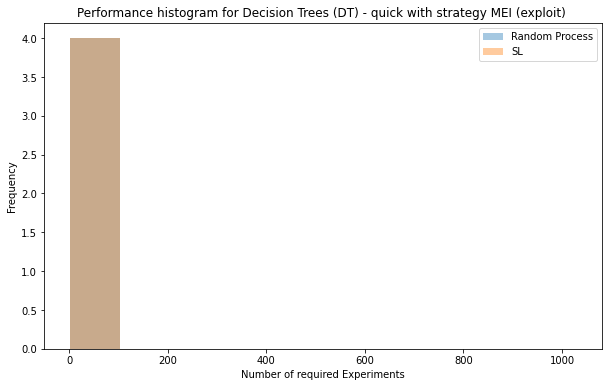

In [16]:
tab